In [1]:
import numpy as np
import pandas as pd
import os
from functools import reduce

from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture

from sklearn.manifold import TSNE,MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)

# Lectura de datos

Se usarán los datos que ya fueron tratados en el primer código.

In [2]:
df=pd.read_csv('df.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tax_surcharge_and_tolls,Dia_del_año,Hora_inicio,Duración_minutos
0,2,2018-09-22 23:58:56,2018-09-23 00:04:00,1.0,0.60,1,N,234,107,1,5.0,0.5,0.5,1.26,0.0,0.3,7.56,0.8,265,23,5.066667
1,2,2018-09-22 23:47:40,2018-09-23 00:18:37,1.0,11.57,1,N,163,28,1,35.5,0.5,0.5,9.20,0.0,0.3,46.00,0.8,265,23,30.950000
2,2,2018-09-22 23:15:19,2018-09-22 23:27:49,1.0,1.28,1,N,186,230,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,0.8,265,23,12.500000
3,1,2018-09-23 00:27:41,2018-09-23 00:45:42,1.0,5.30,1,N,146,238,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.8,266,0,18.016667
4,2,2018-09-23 00:06:32,2018-09-23 00:13:09,1.0,1.35,1,N,239,143,1,7.0,0.5,0.5,1.00,0.0,0.3,9.30,0.8,266,0,6.616667


In [3]:
# Fechas en formato manejable
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

Se crea un catalogo de fechas para que al final sea más fácil ver que días están en cada cluster.

In [4]:
cat_fh=df[['tpep_pickup_datetime','Dia_del_año']].copy()
cat_fh['tpep_pickup_datetime']=cat_fh['tpep_pickup_datetime'].map(lambda x:x.date())
cat_fh=cat_fh.drop_duplicates()
cat_fh.sort_values('Dia_del_año',inplace=True)
cat_fh.reset_index(inplace=True)
cat_fh.drop('index',axis=1,inplace=True)
cat_fh.columns=['Fecha','Dia_del_año']
cat_fh.head(2)

,Fecha,Dia_del_año
0,2018-01-01,1
1,2018-01-02,2


# Ingeniería de datos

Con los datos que se tienen se creará una tabla que divida la varianza en más variables para producir un mejor modelo

In [5]:
varc =['Duración_minutos','passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'tip_amount','tax_surcharge_and_tolls']
vard=['VendorID','payment_type','RatecodeID']
um=['Dia_del_año']

Se rellenarán con ceros los valores ausentes ya que por el tipo de datos que se manejan usualmente significa que no hubo viajes y por lo tanto no hay dinero ni tiempo recorrido.

In [6]:
def piv_cat(df,v):
    aux=df.pivot_table(index=um,
                 columns=v,
                 values=varc,
                 aggfunc=['min','max','sum','mean','median']
    ).fillna(0)
    aux.columns = ["v_%s_"%v+"".join(str(x[2]))+"_"+"".join(x[1])+"_"+"".join(x[0]) for x in aux.columns]
    return aux

In [7]:
cat =reduce(lambda x,y:pd.merge( x,y,on=um,how='inner'), map(lambda v: piv_cat(df,v),vard)  )
cat.head()

,v_VendorID_1_Duración_minutos_min,v_VendorID_2_Duración_minutos_min,v_VendorID_1_extra_min,v_VendorID_2_extra_min,v_VendorID_1_fare_amount_min,v_VendorID_2_fare_amount_min,v_VendorID_1_passenger_count_min,v_VendorID_2_passenger_count_min,v_VendorID_1_tax_surcharge_and_tolls_min,v_VendorID_2_tax_surcharge_and_tolls_min,v_VendorID_1_tip_amount_min,v_VendorID_2_tip_amount_min,v_VendorID_1_trip_distance_min,v_VendorID_2_trip_distance_min,v_VendorID_1_Duración_minutos_max,v_VendorID_2_Duración_minutos_max,v_VendorID_1_extra_max,v_VendorID_2_extra_max,v_VendorID_1_fare_amount_max,v_VendorID_2_fare_amount_max,v_VendorID_1_passenger_count_max,v_VendorID_2_passenger_count_max,v_VendorID_1_tax_surcharge_and_tolls_max,v_VendorID_2_tax_surcharge_and_tolls_max,v_VendorID_1_tip_amount_max,v_VendorID_2_tip_amount_max,v_VendorID_1_trip_distance_max,v_VendorID_2_trip_distance_max,v_VendorID_1_Duración_minutos_sum,v_VendorID_2_Duración_minutos_sum,v_VendorID_1_extra_sum,v_VendorID_2_extra_sum,v_VendorID_1_fare_amount_sum,v_VendorID_2_fare_amount_sum,v_VendorID_1_passenger_count_sum,v_VendorID_2_passenger_count_sum,v_VendorID_1_tax_surcharge_and_tolls_sum,v_VendorID_2_tax_surcharge_and_tolls_sum,v_VendorID_1_tip_amount_sum,v_VendorID_2_tip_amount_sum,v_VendorID_1_trip_distance_sum,v_VendorID_2_trip_distance_sum,v_VendorID_1_Duración_minutos_mean,v_VendorID_2_Duración_minutos_mean,v_VendorID_1_extra_mean,v_VendorID_2_extra_mean,v_VendorID_1_fare_amount_mean,v_VendorID_2_fare_amount_mean,v_VendorID_1_passenger_count_mean,v_VendorID_2_passenger_count_mean,v_VendorID_1_tax_surcharge_and_tolls_mean,v_VendorID_2_tax_surcharge_and_tolls_mean,v_VendorID_1_tip_amount_mean,v_VendorID_2_tip_amount_mean,v_VendorID_1_trip_distance_mean,v_VendorID_2_trip_distance_mean,v_VendorID_1_Duración_minutos_median,v_VendorID_2_Duración_minutos_median,v_VendorID_1_extra_median,v_VendorID_2_extra_median,v_VendorID_1_fare_amount_median,v_VendorID_2_fare_amount_median,v_VendorID_1_passenger_count_median,v_VendorID_2_passenger_count_median,v_VendorID_1_tax_surcharge_and_tolls_median,v_VendorID_2_tax_surcharge_and_tolls_median,v_VendorID_1_tip_amount_median,v_VendorID_2_tip_amount_median,v_VendorID_1_trip_distance_median,v_VendorID_2_trip_distance_median,v_payment_type_1_Duración_minutos_min,v_payment_type_2_Duración_minutos_min,v_payment_type_3_Duración_minutos_min,v_payment_type_4_Duración_minutos_min,v_payment_type_1_extra_min,v_payment_type_2_extra_min,v_payment_type_3_extra_min,v_payment_type_4_extra_min,v_payment_type_1_fare_amount_min,v_payment_type_2_fare_amount_min,v_payment_type_3_fare_amount_min,v_payment_type_4_fare_amount_min,v_payment_type_1_passenger_count_min,v_payment_type_2_passenger_count_min,v_payment_type_3_passenger_count_min,v_payment_type_4_passenger_count_min,v_payment_type_1_tax_surcharge_and_tolls_min,v_payment_type_2_tax_surcharge_and_tolls_min,v_payment_type_3_tax_surcharge_and_tolls_min,v_payment_type_4_tax_surcharge_and_tolls_min,v_payment_type_1_tip_amount_min,v_payment_type_2_tip_amount_min,v_payment_type_3_tip_amount_min,v_payment_type_4_tip_amount_min,v_payment_type_1_trip_distance_min,v_payment_type_2_trip_distance_min,v_payment_type_3_trip_distance_min,v_payment_type_4_trip_distance_min,v_payment_type_1_Duración_minutos_max,v_payment_type_2_Duración_minutos_max,v_payment_type_3_Duración_minutos_max,v_payment_type_4_Duración_minutos_max,v_payment_type_1_extra_max,v_payment_type_2_extra_max,v_payment_type_3_extra_max,v_payment_type_4_extra_max,v_payment_type_1_fare_amount_max,v_payment_type_2_fare_amount_max,v_payment_type_3_fare_amount_max,v_payment_type_4_fare_amount_max,v_payment_type_1_passenger_count_max,v_payment_type_2_passenger_count_max,v_payment_type_3_passenger_count_max,v_payment_type_4_passenger_count_max,v_payment_type_1_tax_surcharge_and_tolls_max,v_payment_type_2_tax_surcharge_and_tolls_max,v_payment_type_3_tax_surcharge_and_tolls_max,v_payment_type_4_tax_surcharge_and_tolls_max,v_payment_type_1_tip_amount_max,v_payment_typ

Como los valores son positivos podemos intuir que si la media es cero la columna esta llena de ceros y por lo tanto no aporta información útil, por lo que se eliminarán.

In [13]:
columnas=list(cat.describe().T['mean'].loc[ cat.describe().T['mean'] == 0].index)
columnas

['v_VendorID_1_extra_min',
 'v_VendorID_2_extra_min',
 'v_VendorID_1_tip_amount_min',
 'v_VendorID_2_tip_amount_min',
 'v_payment_type_1_extra_min',
 'v_payment_type_2_extra_min',
 'v_payment_type_2_tip_amount_min',
 'v_payment_type_3_tip_amount_min',
 'v_payment_type_4_tip_amount_min',
 'v_payment_type_4_tip_amount_max',
 'v_payment_type_4_tip_amount_sum',
 'v_payment_type_4_tip_amount_mean',
 'v_payment_type_2_tip_amount_median',
 'v_payment_type_4_tip_amount_median',
 'v_RatecodeID_1_extra_min',
 'v_RatecodeID_5_extra_min',
 'v_RatecodeID_1_tip_amount_min',
 'v_RatecodeID_5_extra_max',
 'v_RatecodeID_5_extra_sum',
 'v_RatecodeID_5_extra_mean',
 'v_RatecodeID_5_extra_median']

Y podemos corroborar con un vistazo rapido que en efecto no aportan información.

array([[<AxesSubplot:title={'center':'v_VendorID_1_extra_min'}>,
        <AxesSubplot:title={'center':'v_VendorID_2_extra_min'}>,
        <AxesSubplot:title={'center':'v_VendorID_1_tip_amount_min'}>,
        <AxesSubplot:title={'center':'v_VendorID_2_tip_amount_min'}>,
        <AxesSubplot:title={'center':'v_payment_type_1_extra_min'}>],
       [<AxesSubplot:title={'center':'v_payment_type_2_extra_min'}>,
        <AxesSubplot:title={'center':'v_payment_type_2_tip_amount_min'}>,
        <AxesSubplot:title={'center':'v_payment_type_3_tip_amount_min'}>,
        <AxesSubplot:title={'center':'v_payment_type_4_tip_amount_min'}>,
        <AxesSubplot:title={'center':'v_payment_type_4_tip_amount_max'}>],
       [<AxesSubplot:title={'center':'v_payment_type_4_tip_amount_sum'}>,
        <AxesSubplot:title={'center':'v_payment_type_4_tip_amount_mean'}>,
        <AxesSubplot:title={'center':'v_payment_type_2_tip_amount_median'}>,
        <AxesSubplot:title={'center':'v_payment_type_4_tip_amount_me

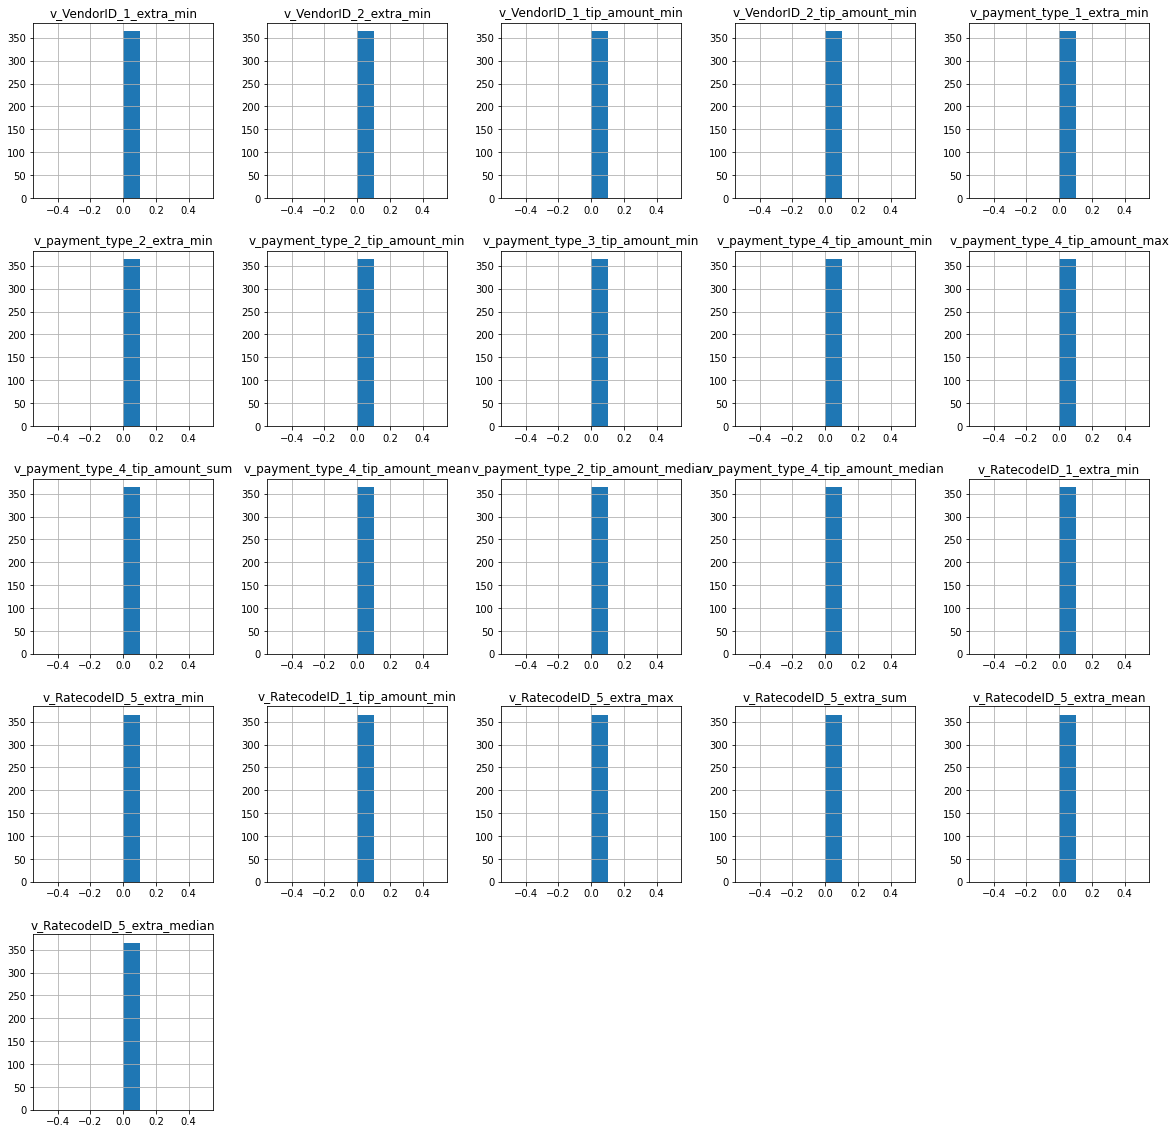

In [32]:
cat[columnas].hist(figsize=(20,20))

In [14]:
cat.drop(columnas,axis=1,inplace=True)

In [15]:
cat=cat.merge(cat_fh,on='Dia_del_año',how='inner')

## Creación de nuevas variables categóricas 

Seleccionaremos las variables que se usaran como indicadores de los clusters que habrá, en este caso serán 3. Y crearemos una tabla con categorías  que este asociada con los valores de las variables que se usarán para identificar los clusters. De esta forma las tendremos en forma continua y categórica.

La cantidad de categorías aunque se presente aquí se decidirá hasta el final cuando se analice el perfilamiento. La separación de las categorías se hará en base a los percentiles, por lo que será fácil cambiar la cantidad de categorías y ejecutar el proceso nuevamente.

In [10]:
df=df.assign(Viajes=1)

In [11]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tax_surcharge_and_tolls,Dia_del_año,Hora_inicio,Duración_minutos,Viajes
0,2,2018-09-22 23:58:56,2018-09-23 00:04:00,1.0,0.60,1,N,234,107,1,5.0,0.5,0.5,1.26,0.0,0.3,7.56,0.8,265,23,5.066667,1
1,2,2018-09-22 23:47:40,2018-09-23 00:18:37,1.0,11.57,1,N,163,28,1,35.5,0.5,0.5,9.20,0.0,0.3,46.00,0.8,265,23,30.950000,1
2,2,2018-09-22 23:15:19,2018-09-22 23:27:49,1.0,1.28,1,N,186,230,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,0.8,265,23,12.500000,1
3,1,2018-09-23 00:27:41,2018-09-23 00:45:42,1.0,5.30,1,N,146,238,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.8,266,0,18.016667,1
4,2,2018-09-23 00:06:32,2018-09-23 00:13:09,1.0,1.35,1,N,239,143,1,7.0,0.5,0.5,1.00,0.0,0.3,9.30,0.8,266,0,6.616667,1


In [12]:
var_cat=['trip_distance','total_amount','Viajes']
fun='sum'
categorias=reduce(lambda x,y:pd.merge(x,y,on=um,how='inner'),
                  map(lambda v:df.groupby(um)[v].agg(fun),var_cat) ).reset_index()

In [13]:
# Funcion para saber si algo es un número
def is_number(n):
    try:
            float(n)  
    except ValueError:
           return False
    return True

In [14]:
def categorizar(datos,v,indice):
    aux=datos.copy()
    cotas=list(categorias.describe()[[v]].T[['min','25%','50%','75%','max']].iloc[0])
    calif=['Baja','Media baja','Media alta','Alta']
    for i in range(1,len(cotas)):
        rem=aux[v].loc[aux[v].map(lambda x: True if (is_number(x)==True and x<cotas[i] and x >=cotas[i-1]) else False )].to_list()
        aux[v]=aux[v].replace(to_replace=rem,value=calif[i-1])
    return aux[[v]+indice]

In [15]:
categoricas=reduce(lambda x,y:pd.merge(x,y,on=um,how='inner'),map(lambda v:categorizar(categorias,v,um),var_cat))
categoricas

,trip_distance,Dia_del_año,total_amount,Viajes
0,Media baja,1,Baja,Media baja
1,Media baja,2,Baja,Baja
2,Media alta,3,Media alta,Baja
3,Baja,4,Baja,Baja
4,Baja,5,Baja,Baja
...,...,...,...,...
360,Media alta,361,Media baja,Baja
361,Baja,362,Baja,Baja
362,Baja,363,Baja,Baja
363,Baja,364,Baja,Baja


# Análisis exploratorio

In [553]:
ol = cat.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

In [ ]:
aux = cat.copy()
suma=0
columnas=[]
for v,li,ls in ol:
    filas = list(aux[[v]].loc[aux[v] < li ].index)
    filas.extend( list(aux[[v]].loc[aux[v] > ls ].index) )
    suma = suma + len(filas)
    if len(filas) != 0:
        columnas.append(v)
        print(v,li,ls)
        print("Cantidad de filas con extremos =",len(filas))
        print("\n")
    aux.drop(filas,axis=0,inplace = True)
print( "Extremos totales = ", suma) # Se ocultarón los valores por que son demasiados

La mayoría de filas tiene valores extremos por lo que no se eliminaran y se vigilarán más bien.

# Modelo

In [24]:
cat=cat.merge(categoricas,on=um,how='inner')

In [167]:
varc = [v for v in cat.columns if v[:2]=='v_']
X=cat[varc].copy()

Se usará mds y tsne para visualizar los clusters. Con PCA no es posible pues la varianza no se puede explicar con dos variables.

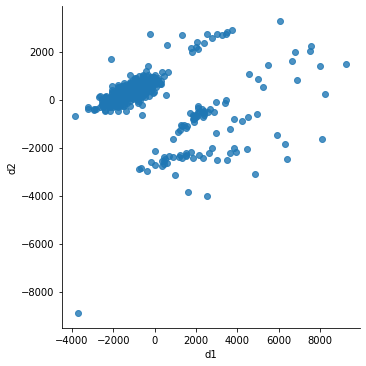

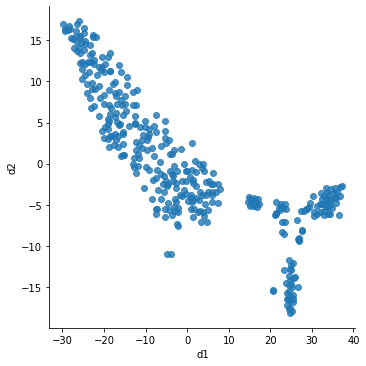

In [27]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)

mds = MDS(n_components=2,n_jobs=-1)
tsne = TSNE(n_components=2,n_jobs=-1)

Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])

sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

## K-Means

Se usará k-medias para poder analizar la inercia y tener una idea de cuantos clusters hacer.

In [560]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

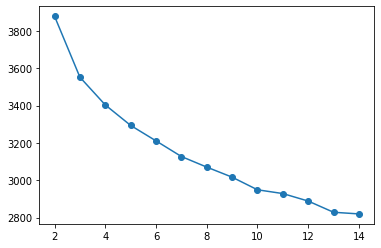

In [561]:
l_in = []
for k in range(2,15):
    cl = KMeans(n_clusters=k,)
    cl.fit(Xs)
    l_in.append(cl.inertia_)
plt.plot(range(2,15),l_in,marker='o')

Las mediciones con la inercia parecen indicar que deben ser 3 o 6 , e incluso tal vez 10.

## Gaussian

Con el modelo de gaussianos mixtos es con el que se hará inferencia sobre los resultados por su versatilidad al momento de crear clusters.

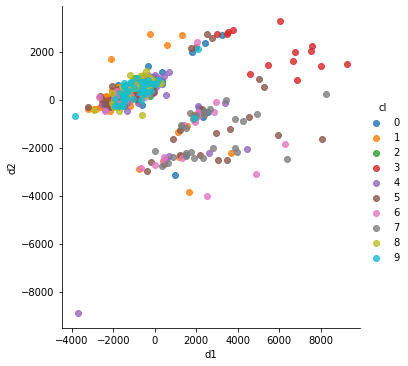

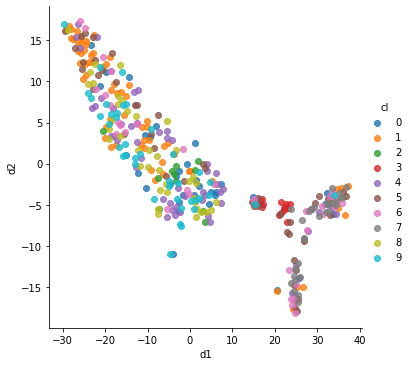

In [29]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

cluster = GaussianMixture(n_components=10)

Xs['cl'] = Xm['cl'] = Xt['cl'] = cluster.fit_predict(Xs)
Xt[var_cat]=Xm[var_cat]=cat[var_cat]

sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

El modelo muestra pocas cosas a simple vista, solo tal vez que el cluster 3 está muy separado.

# Perfilamiento

In [32]:
Xs[var_cat]=categorias[var_cat]

Xs['cl'].value_counts(False).sort_index()

0    35
1    67
2    12
3    14
4    52
5    45
6    33
7    28
8    39
9    40
Name: cl, dtype: int64

Se agruparán los datos a partir de los clusters con una función de agregación que permita entender las diferencias en los clusters.
Se trabajará con la mediana principalmente por la cantidad de datos extremos que hay presentes.

In [33]:
perfilamiento = Xs[['cl']+var_cat].groupby('cl').median().reset_index()
perfilamiento

,cl,trip_distance,total_amount,Viajes
0,0,475.870,2775.430,163.0
1,1,398.780,2149.150,136.0
2,2,451.035,2724.875,161.0
3,3,1048.575,5719.050,341.5
4,4,469.790,2678.855,152.0
5,5,423.600,2351.760,149.0
6,6,434.960,2344.610,150.0
7,7,448.640,2560.290,157.5
8,8,438.910,2537.490,161.0
9,9,442.960,2524.370,162.0


In [44]:
perfilamiento_cat=reduce(lambda x,y:pd.merge(x,y,on=['cl'],how='inner'),map(lambda v:categorizar(perfilamiento,v,['cl']),var_cat))[['cl']+var_cat]
perfilamiento_cat

,cl,trip_distance,total_amount,Viajes
0,0,Media alta,Media alta,Media alta
1,1,Media baja,Baja,Media baja
2,2,Media alta,Media alta,Media alta
3,3,Alta,Alta,Alta
4,4,Media alta,Media alta,Media baja
5,5,Media baja,Media baja,Media baja
6,6,Media baja,Media baja,Media baja
7,7,Media alta,Media alta,Media alta
8,8,Media baja,Media alta,Media alta
9,9,Media baja,Media alta,Media alta


Muchas categorías parecen repetirse en los clusters, por lo que se podría pensar que deben ser menos clusters. Por lo que se realizará un **ANOVA** para cerciorarse de que haya diferencia estadística entre los clusters para cata variable a considerar.

Pero antes veremos si hay algún patrón visible a simple vista en las fechas para los clusters que muestran mayor separación en el **MSD**, que es el más claro de los modelos de visualización,

In [38]:
Xs['Fecha']=cat_fh['Fecha']

Notamos que el cluster 3 estaba separado de los demás en la visualización del MDS y aquí  vemos que solo hay días de marzo, además de que es el único que que presenta mediciones altas en todas las variables a pesar de que estan tratados con la mediana para que sea robusta con datos extremos.

In [36]:
Xs.loc[Xs['cl']==3][['Fecha']]

,Fecha
63,2018-03-05
64,2018-03-06
66,2018-03-08
67,2018-03-09
70,2018-03-12
72,2018-03-14
73,2018-03-15
74,2018-03-16
80,2018-03-22
81,2018-03-23


## Prueba de ANOVA

Debido a que no es muy claro cuantos clusters seleccionar con el método de k-means, se hará un ANOVA para ver si hay diferencias significativas entre las medias de las variables al separarlas en los clusters marcados, de esta forma veremos si sobra algún cluster de los que hemos seleccionado.

Se usará el ANOVA no parametrico para no tener que probar los supuestos del ANOVA parametrico y agilizar este proceso.

Con esta función para transformar datos se podrá obtener una tabla donde los *tratamientos* serán los clusters para cada variable categórica/continua que usamos.

Se rellenarán con ceros los valores ausentes ya que es razonable pensar que si cada fila es una observación para los tratamientos entonces si hay un valor ausente es que no se recorrió nada de tiempo o no se gasto nada de dinero. 

In [41]:
def transform(Xs,v):
    k=Xs[['cl']+[v]]
    k=k.sort_values('cl')
    k=k.reset_index()
    k.drop('index',axis=1,inplace=True)
    lista=list(k[['cl']].value_counts().sort_index())
    new_indice =[1]
    m=0
    cont=1
    for i in range(1,len(k)):
        cont=cont+1
        if cont > lista[m]:
            cont=1
            m+=1
        new_indice.append(cont)
    new_indice=pd.Series(new_indice)
         
    k['New_indice']=new_indice
    k=k.pivot(index='New_indice',columns='cl').fillna(0).reset_index(drop=True)
    k.columns=['cl_'+"".join(str(x[1])) for x in k.columns]
    return k

In [59]:
distancia=transform(Xs,var_cat[0])
ingresos=transform(Xs,var_cat[1])
viajes=transform(Xs,var_cat[2])

Primero lo analizaremos con un diagrama de caja-bigote para ver si hay diferencias evidentes.

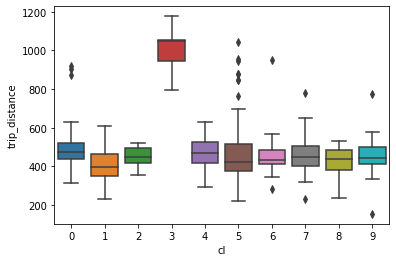

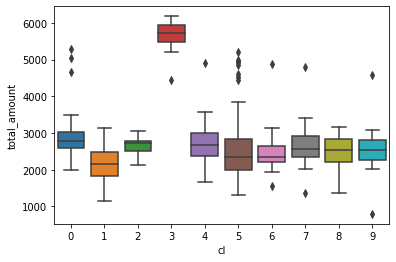

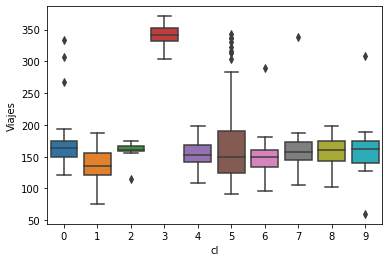

In [66]:
for v in var_cat:
    aux=Xs[['cl']+[v]]
    plt.figure()
    sns.boxplot(x='cl',y=v,data=aux)

Tal parece que el único cluster realmente diferente es $3$, mientras que los otros son realmente parecidos, aunque algunos presentan valores extremos que los hacen separarse un poco del resto. En las tres variables los valores son realmente parecidos, con pequeñas diferencias pero parecen estar muy relacionadas las tres variables, lo que es por otro lado un tanto evidente evidente. Aunque presentan algunas diferencias menores

In [67]:
print(kruskal(*[ distancia[v] for v in distancia.columns  ]))
print(kruskal(*[ ingresos[v] for v in ingresos.columns  ]))
print(kruskal(*[ viajes[v] for v in viajes.columns  ]))

KruskalResult(statistic=82.91873403128889, pvalue=4.243913083548507e-14)
KruskalResult(statistic=77.1694356780192, pvalue=5.88591516280216e-13)
KruskalResult(statistic=74.68583854533226, pvalue=1.822865560753452e-12)


En las tres pruebas nos indica que hay fuertes diferencias estadísticas. Lo cual parece evidente en el caso del cluster 3, pero con los otros no resulta tan claro ver que en efecto son diferentes, por lo que ejecutaremos unas pruebas post-hoc no parametricas para ver cuales son los que presentan diferencias. Se usará la prueba de *holm* que es la recomendada tras haber hecho una prueba de Kruskal-Wallis.

Como es una comparación de pares, tendremos que cuando en la matriz haya un valor menor a *0.05*, que es la significacncia usual los clusters para la variable en cuestión presentan diferencias significativas.

In [81]:
import scikit_posthocs as sp

In [128]:
def prueba_posth(Xs,var_cat):
    for v in var_cat:
        data=Xs[['cl']+[v]]
        mat=sp.posthoc_conover(data, val_col=v, group_col='cl', p_adjust = 'holm')
        print("Clusters sin sin diferencias significativas para ",v)
        for i in range(len(mat)):
            print(" Cluster",i)
            print(mat[[i]].loc[mat.loc[i]>0.05])
            print("Hay ",len(mat[[i]].loc[mat.loc[i]>0.05])," clustera que se parecen a este")
            print()
        print("\n")

In [104]:
prueba_posth(Xs,var_cat)

Clusters sin sin diferencias significativas para  trip_distance
 Cluster 0
          0
0  1.000000
2  1.000000
4  1.000000
5  1.000000
6  1.000000
7  1.000000
8  0.563767
9  1.000000
Hay  8  clustera que se parecen a este

 Cluster 1
          1
1  1.000000
2  0.414138
5  0.055965
6  0.211395
7  0.074658
8  0.337147
Hay  6  clustera que se parecen a este

 Cluster 2
          2
0  1.000000
1  0.414138
2  1.000000
4  1.000000
5  1.000000
6  1.000000
7  1.000000
8  1.000000
9  1.000000
Hay  9  clustera que se parecen a este

 Cluster 3
     3
3  1.0
Hay  1  clustera que se parecen a este

 Cluster 4
     4
0  1.0
2  1.0
4  1.0
5  1.0
6  1.0
7  1.0
8  1.0
9  1.0
Hay  8  clustera que se parecen a este

 Cluster 5
          5
0  1.000000
1  0.055965
2  1.000000
4  1.000000
5  1.000000
6  1.000000
7  1.000000
8  1.000000
9  1.000000
Hay  9  clustera que se parecen a este

 Cluster 6
          6
0  1.000000
1  0.211395
2  1.000000
4  1.000000
5  1.000000
6  1.000000
7  1.000000
8  1.000000
9 

Las pruebas muestran que entre los clusters hay muchos que son muy parecidos, por lo que hay muchos que sobran. Por fortuna no tenemos que elegir cuales retirar, sino simplemente bajar el número de clusters a realizar.

El cluster 3 siempre esta aislado, y podemos ver que en general 0,1 y 5 tienes pocos clusters a los que se parecen, por lo que ejecutaremos de nuevo la clusterización con el modelo de gaussianos mixtos para diversas cantidades de clusters y veremos que resulta.

# Segunda ejecución de los modelos

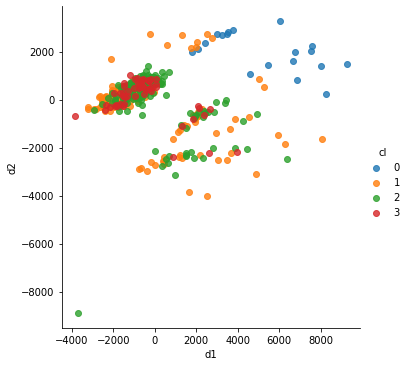

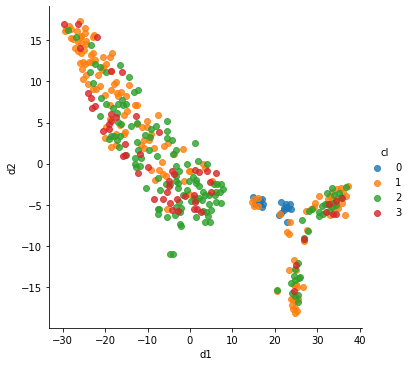

In [188]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc)

cluster = GaussianMixture(n_components=4)

Xs['cl'] = Xm['cl'] = Xt['cl'] = cluster.fit_predict(Xs)
Xt[var_cat]=Xm[var_cat]=cat[var_cat]

sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='cl')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='cl')

No parece muy clara la separación de clusters, aunque el cluster 0 esta muy separado de los demás y 2 y 3 están muy cerca siempre.

# Perfilamiento

In [189]:
Xs[var_cat]=categorias[var_cat]

Xs['cl'].value_counts(False).sort_index()

0     19
1    146
2    144
3     56
Name: cl, dtype: int64

In [200]:
perfilamiento = Xs[['cl']+var_cat].groupby('cl').median().reset_index()
perfilamiento

,cl,trip_distance,total_amount,Viajes
0,0,969.010,5507.990,338.0
1,1,414.870,2241.915,143.0
2,2,463.265,2660.455,161.0
3,3,443.180,2532.970,158.5


In [201]:
perfilamiento_cat=reduce(lambda x,y:pd.merge(x,y,on=['cl'],how='inner'),map(lambda v:categorizar(perfilamiento,v,['cl']),var_cat))[['cl']+var_cat]
perfilamiento_cat

,cl,trip_distance,total_amount,Viajes
0,0,Alta,Alta,Alta
1,1,Media baja,Media baja,Media baja
2,2,Media alta,Media alta,Media alta
3,3,Media baja,Media alta,Media alta


In [192]:
Xs['Fecha']=cat_fh['Fecha']

In [243]:
Xs.loc[Xs['cl']==0][['Fecha']]

,Fecha
59,2018-03-01
60,2018-03-02
63,2018-03-05
64,2018-03-06
66,2018-03-08
67,2018-03-09
70,2018-03-12
72,2018-03-14
73,2018-03-15
74,2018-03-16


Podemos notar a marzo nuevamente aparecer en el cluster de más alta demanda, lo cual es bastante extraño.

## ANOVA

Se realiza nuevamente el ANOVA para estar más seguros sobre las decisiones tomadas.

In [194]:
distancia=transform(Xs,var_cat[0])
ingresos=transform(Xs,var_cat[1])
viajes=transform(Xs,var_cat[2])

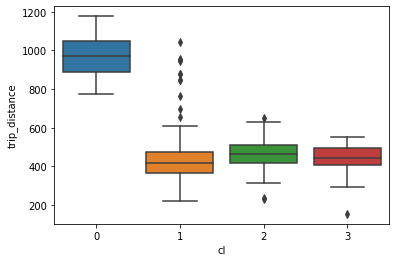

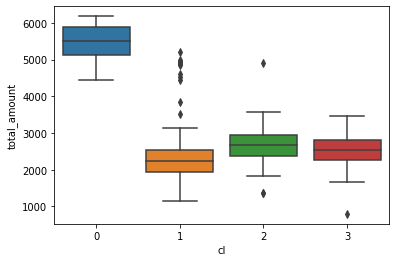

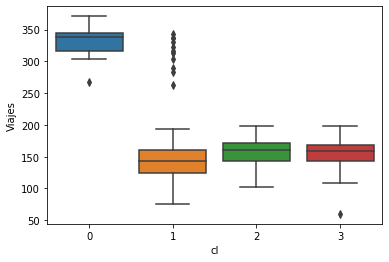

In [195]:
for v in var_cat:
    aux=Xs[['cl']+[v]]
    plt.figure()
    sns.boxplot(x='cl',y=v,data=aux)

In [196]:
print(kruskal(*[ distancia[v] for v in distancia.columns  ]))
print(kruskal(*[ ingresos[v] for v in ingresos.columns  ]))
print(kruskal(*[ viajes[v] for v in viajes.columns  ]))

KruskalResult(statistic=216.90890552800425, pvalue=9.351836644237361e-47)
KruskalResult(statistic=223.2369057488167, pvalue=4.0084588773576595e-48)
KruskalResult(statistic=211.09557895586852, pvalue=1.688107096932981e-45)


In [197]:
prueba_posth(Xs,var_cat)

Clusters sin sin diferencias significativas para  trip_distance
 Cluster 0
     0
0  1.0
Hay  1  clustera que se parecen a este

 Cluster 1
     1
1  1.0
Hay  1  clustera que se parecen a este

 Cluster 2
          2
2  1.000000
3  0.214046
Hay  2  clustera que se parecen a este

 Cluster 3
          3
2  0.214046
3  1.000000
Hay  2  clustera que se parecen a este



Clusters sin sin diferencias significativas para  total_amount
 Cluster 0
     0
0  1.0
Hay  1  clustera que se parecen a este

 Cluster 1
     1
1  1.0
Hay  1  clustera que se parecen a este

 Cluster 2
         2
2  1.00000
3  0.05829
Hay  2  clustera que se parecen a este

 Cluster 3
         3
2  0.05829
3  1.00000
Hay  2  clustera que se parecen a este



Clusters sin sin diferencias significativas para  Viajes
 Cluster 0
     0
0  1.0
Hay  1  clustera que se parecen a este

 Cluster 1
     1
1  1.0
Hay  1  clustera que se parecen a este

 Cluster 2
          2
2  1.000000
3  0.563386
Hay  2  clustera que se parecen a

Al final se eligieron 4 clusters para el modelo, pues después de varias pruebas con 4 se consiguion una buena separación entre 0 y 1. Aunque 2 y 3 son muy parecidos, y estadísticamente iguales no se hará de nuevo el modelo por que ha salido una separación bastante buena, ya que en más de una ocasión los los clusters terminaban siendo muy parecidos entre si. Por lo que solo se cambiara el valor en el dataframe.

In [219]:
X_final=Xs[['cl']+var_cat+['Fecha']].copy()
X_final[['cl']]=X_final[['cl']].replace({3:2})
X_final.head()

,cl,trip_distance,total_amount,Viajes,Fecha
0,1,420.44,2054.19,145,2018-01-01
1,2,403.72,2107.89,129,2018-01-02
2,2,483.69,2779.57,134,2018-01-03
3,2,153.88,795.48,60,2018-01-04
4,2,361.85,2010.45,128,2018-01-05


También aquí se probó con la mediana y con la media y ambas ofrecieron resultados similares.

In [224]:
perfilamiento = X_final[['cl']+var_cat].groupby('cl').median().reset_index()
perfilamiento

,cl,trip_distance,total_amount,Viajes
0,0,969.01,5507.990,338
1,1,414.87,2241.915,143
2,2,457.75,2654.835,160


In [225]:
perfilamiento_cat=reduce(lambda x,y:pd.merge(x,y,on=['cl'],how='inner'),map(lambda v:categorizar(perfilamiento,v,['cl']),var_cat))[['cl']+var_cat]
perfilamiento_cat

,cl,trip_distance,total_amount,Viajes
0,0,Alta,Alta,Alta
1,1,Media baja,Media baja,Media baja
2,2,Media alta,Media alta,Media alta


Con el análisis de varianza ya corroboramos que estos 3 clusters son diferentes estadísticamente, y las variables tienen valores muy correlacionados en todos los clusters, por lo que sencillamente podemos decir que el cluster 0 es el de *Alta demanda*, el cluster 1 es el de *Baja demanda* y el cluster 2 el de *Demanda moderada*. Aquí notamos que no hay días de baja demanda, y esto puede deberse a que los días de baja demanda realmente son pocos como para presentarse, de hecho el ahora cluster 2 presenta las menores cantidades de viajes a pesar de ser el de demanda moderada, pues tiene algunos datos extremos. Así como el cluster de *Baja demanda* presenta datos extremos muy altos, aunque son bastante atípicos, pues ni utilizar la media en lugar de la mediana cambio los resultados.

Lo que habría que recalcar en los clusters de baja y alta demanda es que se pueden esperar más de una anomalía, mientras que en el de alta demanda las cosas son bastante estables.

In [242]:
tab=X_final.replace({0:'Alta demanda', 1:'Baja demanda',2:'Demanda moderada'})
tab.head(10)

,cl,trip_distance,total_amount,Viajes,Fecha
0,Baja demanda,420.44,2054.19,145,2018-01-01
1,Demanda moderada,403.72,2107.89,129,2018-01-02
2,Demanda moderada,483.69,2779.57,134,2018-01-03
3,Demanda moderada,153.88,795.48,60,2018-01-04
4,Demanda moderada,361.85,2010.45,128,2018-01-05
5,Baja demanda,436.68,2309.82,154,2018-01-06
6,Baja demanda,393.00,2075.04,149,2018-01-07
7,Baja demanda,608.00,3137.49,174,2018-01-08
8,Baja demanda,405.59,2351.76,154,2018-01-09
9,Demanda moderada,382.90,2327.11,156,2018-01-10


In [244]:
tab.to_csv('tab.csv',index=False)